In [ ]:
import wandb
wandb.login(key="Enter your key")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: theperfectionist0922 (theperfectionist0922-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os
from torch import optim

class CustomCNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg
        self.image_dim = cfg['img_size']
        self.total_compute = 0
        self.input_channels = cfg['input_channel']
        self.output_classes = cfg['output_neuron']

        self.filters = self._get_filters(cfg['filter_organisation'], cfg['no_of_filters'])
        self.activations = self._get_activations(cfg['activation'])

        self.conv_blocks = nn.ModuleList()
        self._create_conv_blocks()

        final_dim = self.image_dim * self.image_dim * self.filters[-1]
        self.flatten_layer = nn.Flatten()
        self.hidden_layer = nn.Linear(final_dim, cfg['dense_layer_size'])
        self.output_layer = nn.Linear(cfg['dense_layer_size'], self.output_classes)

        self.total_compute += final_dim * cfg['dense_layer_size'] + cfg['dense_layer_size']
        self.total_compute += cfg['dense_layer_size'] * self.output_classes + self.output_classes
        print(f"Final Dense Computation: {self.total_compute}")

    def _get_filters(self, mode, base):
        match mode:
            case "same":
                return [base] * 5
            case "double":
                return [base * (2 ** i) for i in range(5)]
            case "half":
                return [base // (2 ** i) for i in range(5)]

    def _get_activations(self, kind):
        match kind:
            case 'ReLU': return [nn.ReLU()] * 5
            case 'GELU': return [nn.GELU()] * 5
            case 'SiLU': return [nn.SiLU()] * 5
            case 'Mish': return [nn.Mish()] * 5

    def _conv_out_size(self, size, kernel, stride, padding):
        return (size - kernel + 2 * padding) // stride + 1

    def _pool_out_size(self, size, kernel, stride, padding, dilation=1):
        return (size + 2 * padding - dilation * (kernel - 1) - 1) // stride + 1

    def _create_conv_blocks(self):
        idx = 0
        in_c = self.input_channels

        while idx < 5:
            out_c = self.filters[idx]
            conv = nn.Conv2d(in_channels=in_c,
                             out_channels=out_c,
                             kernel_size=self.cfg['filter_size'][idx],
                             stride=self.cfg['stride'][idx],
                             padding=self.cfg['padding'][idx])

            activation = self.activations[idx]
            pool = nn.MaxPool2d(kernel_size=self.cfg['pool_filter_size'][idx],
                                stride=self.cfg['pool_stride'][idx],
                                padding=self.cfg['pool_padding'][idx])

            self.conv_blocks.append(nn.Sequential(conv, activation, pool))

            # Computation
            new_dim = self._conv_out_size(self.image_dim,
                                          self.cfg['filter_size'][idx],
                                          self.cfg['stride'][idx],
                                          self.cfg['padding'][idx])

            compute = ((self.cfg['filter_size'][idx] ** 2) * in_c * new_dim ** 2 + 1) * out_c
            self.total_compute += compute
            print(f"Layer {idx+1} Computation: {compute}")

            new_dim = self._pool_out_size(new_dim,
                                          self.cfg['pool_filter_size'][idx],
                                          self.cfg['pool_stride'][idx],
                                          self.cfg['pool_padding'][idx])

            self.image_dim = new_dim
            in_c = out_c
            idx += 1

    def forward(self, x):
        for i, block in enumerate(self.conv_blocks, 1):
            x = block(x)
            print(f"After Layer {i}:", x.shape)

        x = self.flatten_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return F.softmax(x, dim=1)

def prepare_dataloaders(batch_size, img_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    dataset_path = "inaturalist_12K"
    train_set = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform=transform)
    test_set = datasets.ImageFolder(os.path.join(dataset_path, 'val'), transform=transform)

    labels = train_set.classes
    train_subset, val_subset = random_split(train_set, [8000, 1999])

    return (labels,
            DataLoader(train_subset, batch_size=batch_size),
            DataLoader(val_subset, batch_size=batch_size),
            DataLoader(test_set, batch_size=batch_size))

# Config Setup
cfg = {
    'input_channel': 3,
    'output_neuron': 10,
    'filter_organisation': 'same',
    'no_of_filters': 8,
    'filter_size': [3]*5,
    'stride': [1]*5,
    'padding': [0]*5,
    'pool_filter_size': [3]*5,
    'pool_stride': [1]*5,
    'pool_padding': [0]*5,
    'activation': 'ReLU',
    'dense_layer_size': 16,
    'batch_size': 64,
    'img_size': 256,
}

# Model + Data
labels, train_dl, val_dl, test_dl = prepare_dataloaders(cfg['batch_size'], cfg['img_size'])
net = CustomCNN(cfg)
print(net)

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(net.parameters(), lr=1e-4)

# Parameter Count
param_count = sum(p.numel() for p in net.parameters())
print(f"Total Parameters: {param_count}")


Create sweep with ID: tj7rvfaz
Sweep URL: https://wandb.ai/theperfectionist0922-iit-madras/iNaturalist-CNN-2/sweeps/tj7rvfaz


wandb: Agent Starting Run: gxebq4g1 with config:
wandb: 	activation: SiLU
wandb: 	batch_normalization: No
wandb: 	batch_size: 128
wandb: 	data_augmentaion: No
wandb: 	dense_size: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filter_organisation: same
wandb: 	filter_size: [7, 5, 5, 3, 3]
wandb: 	img_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	no_of_filters: 64
wandb: 	optimizer: adam
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


accuracy,▁▂▄▄▅▅▅▆▆▆▆▇▇▇▇▇█████▇███
accuracy,0.3395


wandb: Agent Starting Run: ksqqguwx with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_normalization: Yes
wandb: 	batch_size: 128
wandb: 	data_augmentaion: Yes
wandb: 	dense_size: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 25
wandb: 	filter_organisation: same
wandb: 	filter_size: [3, 3, 3, 3, 3]
wandb: 	img_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	no_of_filters: 64
wandb: 	optimizer: adam


wandb: Ctrl + C detected. Stopping sweep.


Training...
Epoch 1/10 - Val Acc: 0.2985
Epoch 2/10 - Val Acc: 0.3090
Epoch 3/10 - Val Acc: 0.3110
Epoch 4/10 - Val Acc: 0.3170
Epoch 5/10 - Val Acc: 0.3275
Epoch 6/10 - Val Acc: 0.3340
Epoch 7/10 - Val Acc: 0.3355
Epoch 8/10 - Val Acc: 0.3390
Epoch 9/10 - Val Acc: 0.3565
Epoch 10/10 - Val Acc: 0.3670

Test Accuracy: 0.3685

Generating visualization...


/tmp/ipykernel_31/2647792732.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


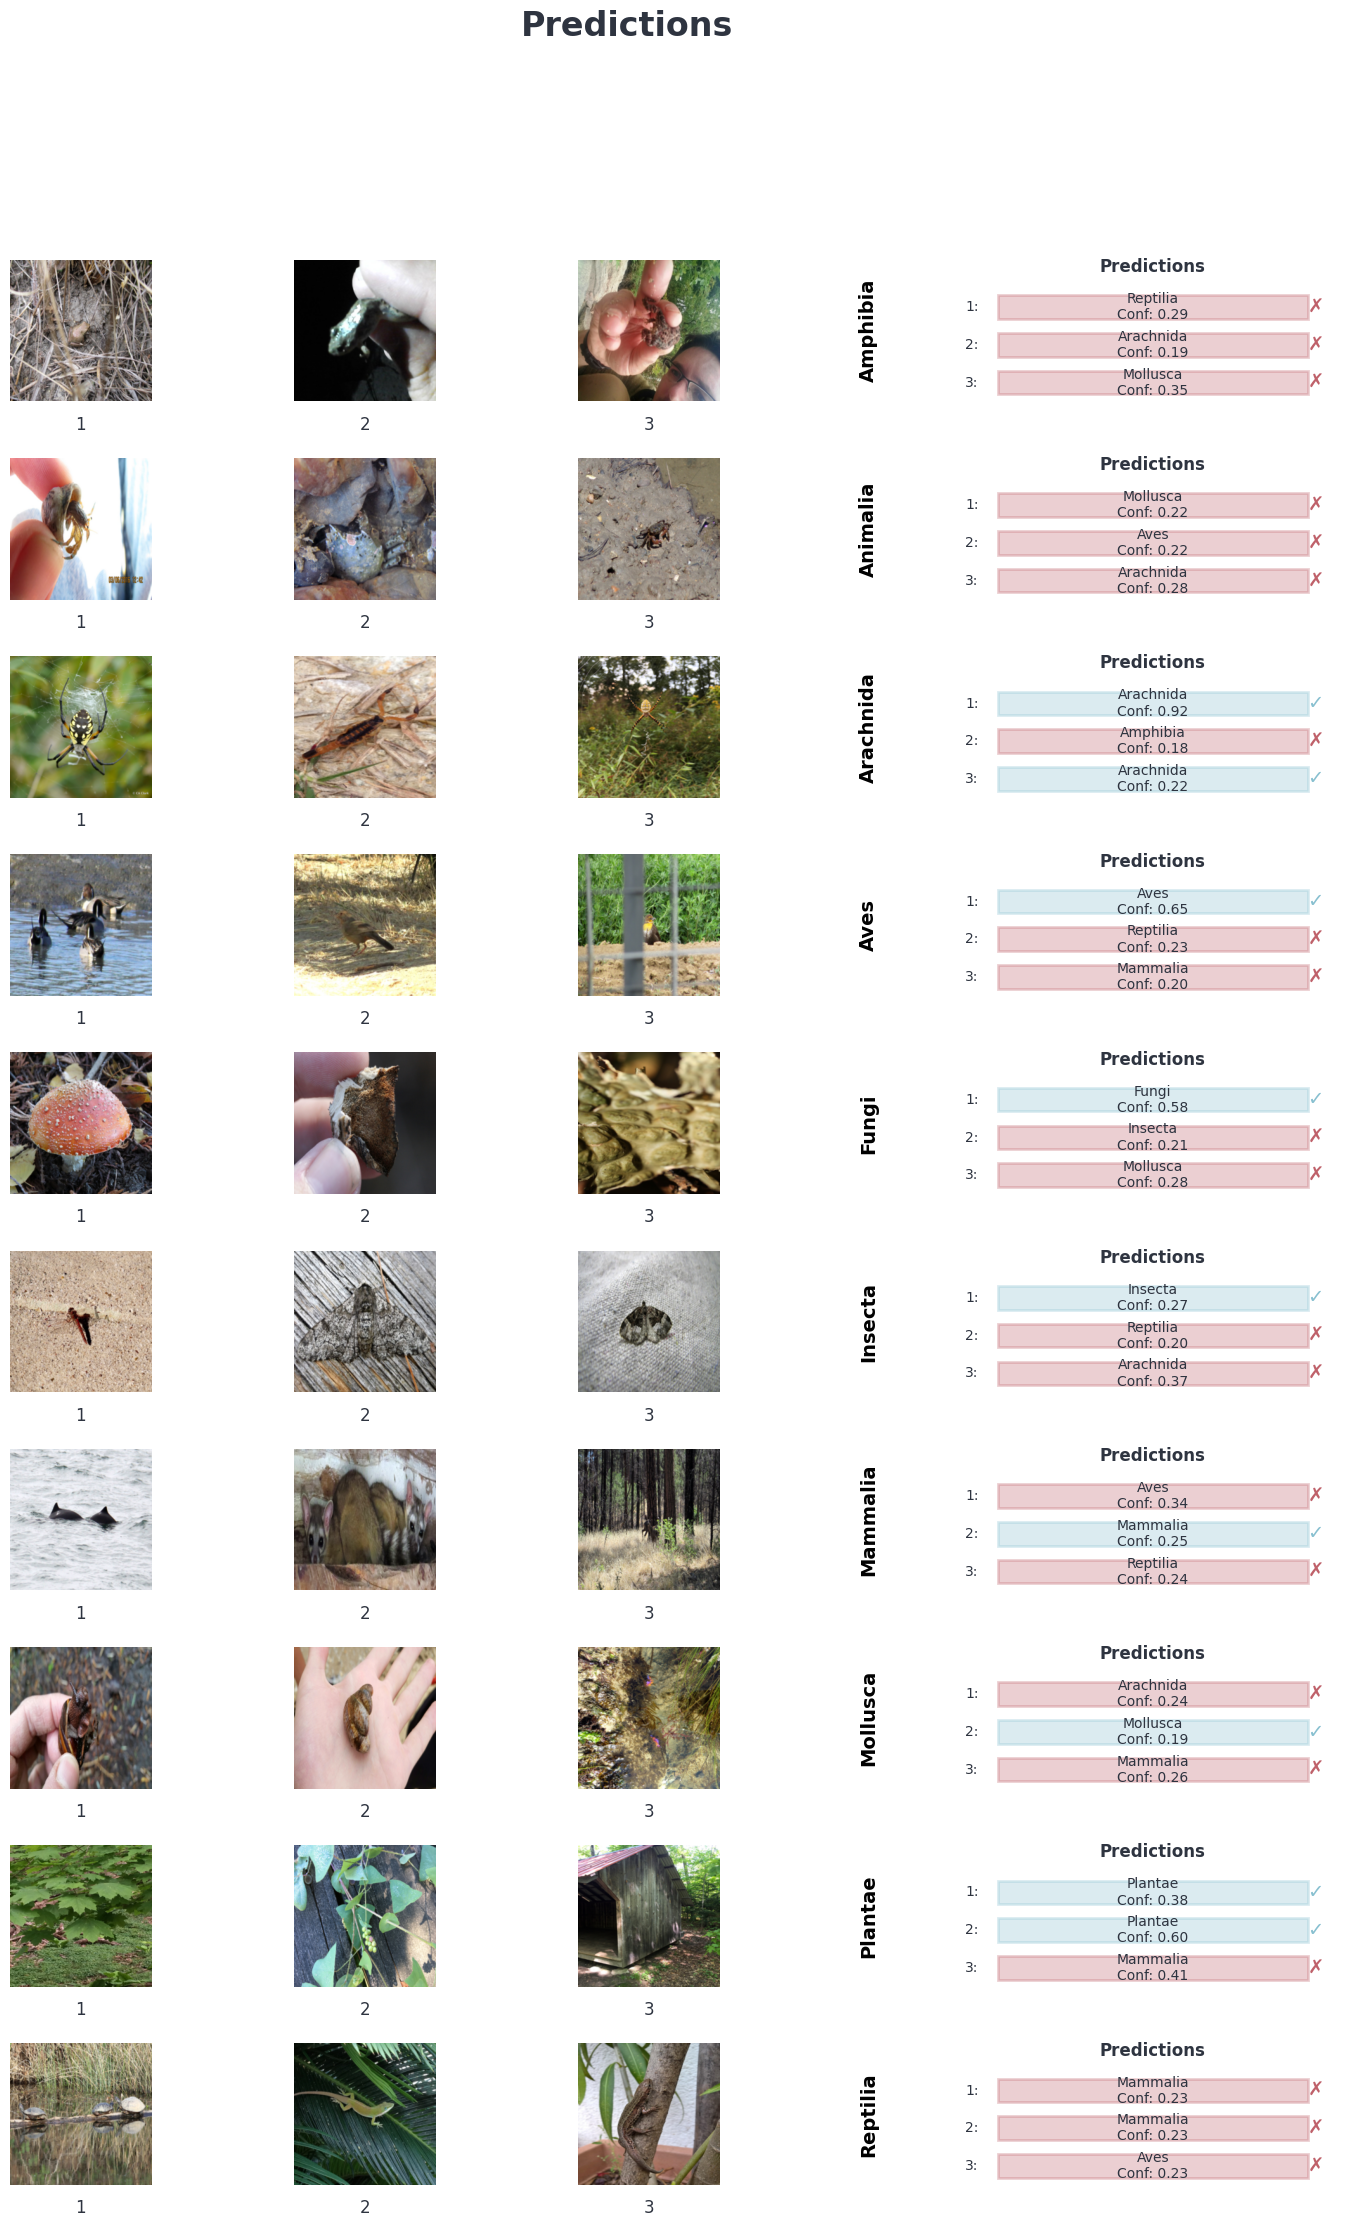

In [ ]:
import os
import random
import numpy as np
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from enum import Enum
from collections import namedtuple

# Device Setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WORKER_THREADS = min(os.cpu_count(), 8)

# Enum for activation selection
class ActivationType(Enum):
    RELU = "ReLU"
    LEAKY_RELU = "LeakyReLU"
    GELU = "GELU"
    SILU = "SiLU"
    MISH = "Mish"

ACTIVATION_MAP = {
    ActivationType.RELU: nn.ReLU,
    ActivationType.LEAKY_RELU: nn.LeakyReLU,
    ActivationType.GELU: nn.GELU,
    ActivationType.SILU: nn.SiLU,
    ActivationType.MISH: nn.Mish
}

# Data transformation logic
def build_transforms(img_size, augment=True):
    base = [transforms.Resize((img_size, img_size)), transforms.ToTensor()]
    if augment:
        aug = [
            transforms.RandomResizedCrop(img_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
        ]
        return transforms.Compose(aug + [transforms.ToTensor()]), transforms.Compose(base)
    return transforms.Compose(base), transforms.Compose(base)

# Stratified dataset split
def stratify(dataset, labels, split_ratio=0.2):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=split_ratio, random_state=42)
    for train_idx, val_idx in splitter.split(np.zeros(len(labels)), labels):
        return train_idx, val_idx

# Data preparation and loading
def fetch_data(path, batch, img_sz, augment):
    train_tf, val_tf = build_transforms(img_sz, augment)
    raw = datasets.ImageFolder(path, transform=train_tf)
    label_arr = np.array([s[1] for s in raw.samples])
    tr_idx, va_idx = stratify(raw, label_arr)
    val_data = datasets.ImageFolder(path, transform=val_tf)

    return (
        DataLoader(Subset(raw, tr_idx), batch_size=batch, shuffle=True, num_workers=WORKER_THREADS, pin_memory=True),
        DataLoader(Subset(val_data, va_idx), batch_size=batch, shuffle=False, num_workers=WORKER_THREADS, pin_memory=True),
        len(raw.classes)
    )

# Network definition
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.conv = self._build_conv_block(config)
        self.flattened_size = self._get_flattened_size(config.img_size)
        self.dense = self._build_fc(config)

    def _build_conv_block(self, cfg):
        filters = [cfg.no_of_filters * (2 if cfg.filter_organisation == 'alt' and i % 2 else 1)
                   for i in range(len(cfg.filter_size))]
        act = ACTIVATION_MAP[ActivationType(cfg.activation)]
        sequence = nn.Sequential()
        in_ch = 3

        i = 0
        while i < len(cfg.filter_size):
            out_ch = filters[i]
            sequence.append(nn.Conv2d(in_ch, out_ch, kernel_size=cfg.filter_size[i], padding=cfg.filter_size[i] // 2))
            if cfg.batch_normalization == 'Yes':
                sequence.append(nn.BatchNorm2d(out_ch))
            sequence.append(act())
            sequence.append(nn.MaxPool2d(kernel_size=2))
            if cfg.dropout > 0:
                sequence.append(nn.Dropout2d(cfg.dropout))
            in_ch = out_ch
            i += 1
        return sequence

    def _get_flattened_size(self, img_sz):
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_sz, img_sz)
            out = self.conv(dummy)
            return out.view(1, -1).size(1)

    def _build_fc(self, cfg):
        act = ACTIVATION_MAP[ActivationType(cfg.activation)]
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, cfg.dense_size),
            act(),
            nn.Dropout(cfg.dropout),
            nn.Linear(cfg.dense_size, cfg.num_classes)
        )

    def forward(self, x):
        return self.dense(self.conv(x))

# Training pipeline
def train_loop(model, loader, criterion, optimizer):
    model.train()
    batch_idx = 0
    while batch_idx < len(loader):
        for inputs, targets in [loader[batch_idx]]:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
        batch_idx += 1

def validate_loop(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        index = 0
        while index < len(loader):
            for inputs, labels in [loader[index]]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            index += 1
    return correct / total

# Main training function
def experiment(cfg=None):
    with wandb.init(config=cfg):
        params = wandb.config
        params = namedtuple("Params", params.keys())(*params.values())

        train_loader, val_loader, classes = fetch_data(
            DATA_PATH, params.batch_size, params.img_size, params.data_augmentaion == 'Yes')

        setattr(params, 'num_classes', classes)

        model = Net(params).to(DEVICE)
        opt = optim.Adam(model.parameters(), lr=params.learning_rate)
        loss_fn = nn.CrossEntropyLoss()

        epoch_counter = 0
        while epoch_counter < params.epochs:
            train_loop(model, train_loader, loss_fn, opt)
            acc = validate_loop(model, val_loader)
            wandb.log({"accuracy": acc})
            epoch_counter += 1

# Sweep and config
SWEEP_CFG = {
    'name': 'vision_hyper_sweep',
    'method': 'bayes',
    'metric': {'goal': 'maximize', 'name': 'accuracy'},
    'parameters': {
        'epochs': {'values': [5,10,15,25]},
        'batch_size': {'values': [32, 64, 128]},
        'learning_rate': {'values': [0.0001,0.00001,0.000001]},
        'dense_size': {'values': [256]},
        'filter_size': {'values': [[7, 5, 5, 3, 3], [11, 7, 5, 3, 3], [3, 3, 3, 3, 3]]},
        'activation': {'values': ['LeakyReLU', 'ReLU', 'GELU', 'SiLU', 'Mish']},
        'filter_organisation': {'values': ['same', 'alt']},
        'no_of_filters': {'values': [64]},
        'data_augmentaion': {'values': ['No', 'Yes']},
        'batch_normalization': {'values': ['Yes', 'No']},
        'dropout': {'values': [0.2, 0.3]},
        'img_size': {'values': [224, 256]},
        'optimizer': {'values': ['adam']}
    }
}

DATA_PATH = "/kaggle/input/nature-922/inaturalist_12K/train"
sweep_id = wandb.sweep(SWEEP_CFG, project="iNaturalist-CNN-2")
wandb.agent(sweep_id, function=experiment)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import models, datasets, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import random

# Set seed and device
torch.manual_seed(43)
np.random.seed(43)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------- Utilities ----------------------------
def log_device():
    print(f"Using device: {DEVICE}")

def get_transforms(train=True):
    base = [transforms.Resize((224, 224)), transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    if train:
        return transforms.Compose([transforms.RandomHorizontalFlip()] + base)
    return transforms.Compose(base)

def compute_accuracy(predictions, labels):
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    return (correct / total) * 100

def forward_pass(model, criterion, data_loader, is_train=False, optimizer=None):
    phase = 'train' if is_train else 'val/test'
    model.train() if is_train else model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_preds, all_labels = [], []

    data_iter = iter(data_loader)
    idx = 0
    while idx < len(data_loader):
        inputs, targets = next(data_iter)
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total_correct += (preds == targets).sum().item()
            total_samples += targets.size(0)

            if is_train:
                loss.backward()
                optimizer.step()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())
        idx += 1

    avg_loss = total_loss / len(data_loader)
    acc = (total_correct / total_samples) * 100

    return avg_loss, acc, all_preds, all_labels

def plot_accuracy(train_hist, val_hist):
    plt.figure(figsize=(10, 6))
    plt.plot(train_hist, label="Train Acc", marker="o", color="blue")
    plt.plot(val_hist, label="Val Acc", marker="s", color="red")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_conf_matrix(y_true, y_pred, classes):
    matrix = confusion_matrix(y_true, y_pred)
    norm = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    sns.heatmap(norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# ---------------------------- Data Loading ----------------------------
def prepare_dataloaders(data_dir="/kaggle/input/nature-922/inaturalist_12K"):
    train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=get_transforms(True))
    test_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=get_transforms(False))

    labels = train_data.classes
    train_subset, val_subset = random_split(train_data, [8000, 1999])

    def make_loader(ds): return DataLoader(ds, batch_size=64, shuffle=True, num_workers=4)

    return labels, make_loader(train_subset), make_loader(val_subset), make_loader(test_data)

# ---------------------------- Training Loop ----------------------------
def train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs, class_names):
    train_accs, val_accs = [], []

    for ep in range(epochs):
        tr_loss, tr_acc, _, _ = forward_pass(model, criterion, train_loader, is_train=True, optimizer=optimizer)
        val_loss, val_acc, _, _ = forward_pass(model, criterion, val_loader)

        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        print(f"Epoch {ep+1}/{epochs} - Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    plot_accuracy(train_accs, val_accs)

    # Final test performance
    tst_loss, tst_acc, y_pred, y_true = forward_pass(model, criterion, test_loader)
    print(f"Test Loss: {tst_loss:.4f}, Test Accuracy: {tst_acc:.2f}%")
    plot_conf_matrix(y_true, y_pred, class_names)

    return model

# ---------------------------- Layer Freezing ----------------------------
def freeze_layers(model, k, strategy):
    children = list(model.named_children())

    match strategy:
        case "first":
            freeze_range = range(k)
        case "middle":
            total = len(children)
            freeze_range = range(total // 3, (2 * total) // 3)
        case "last":
            freeze_range = range(len(children) - k, len(children))
        case _:
            raise ValueError("Strategy must be 'first', 'middle', or 'last'.")

    for idx, (name, layer) in enumerate(children):
        if idx in freeze_range:
            for param in layer.parameters():
                param.requires_grad = False
    print(f"Strategy '{strategy}' applied: frozen layers {list(freeze_range)}")

# ---------------------------- Fine-tune Driver ----------------------------
def fine_tune_model(epoch, k, strategy, optim_type):
    log_device()
    class_labels, train_loader, val_loader, test_loader = prepare_dataloaders()

    model = models.googlenet(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model.to(DEVICE)

    freeze_layers(model, k, strategy)

    optimizer = {
        "adam": lambda: optim.Adam(model.parameters(), lr=0.001),
        "sgd": lambda: optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    }.get(optim_type, lambda: (_ for _ in ()).throw(ValueError("Invalid optimizer")))()

    criterion = nn.CrossEntropyLoss()

    start = time.time()
    model = train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, epoch, class_labels)
    print(f"Total training time: {time.time() - start:.2f}s")

    return model


Using device: cuda
Strategy 'last' applied: frozen layers [14, 15, 16, 17, 18]
Epoch 1/10 - Train Loss: 1.7756, Train Acc: 43.43% | Val Loss: 1.6566, Val Acc: 46.37%
Epoch 2/10 - Train Loss: 1.3916, Train Acc: 59.26% | Val Loss: 1.4740, Val Acc: 54.38%
Epoch 3/10 - Train Loss: 1.2078, Train Acc: 65.81% | Val Loss: 1.4463, Val Acc: 55.78%
Epoch 4/10 - Train Loss: 1.0760, Train Acc: 70.85% | Val Loss: 1.3943, Val Acc: 55.63%
Epoch 5/10 - Train Loss: 0.9661, Train Acc: 74.89% | Val Loss: 1.4295, Val Acc: 54.63%
Epoch 6/10 - Train Loss: 0.8622, Train Acc: 78.31% | Val Loss: 1.2676, Val Acc: 62.23%
Epoch 7/10 - Train Loss: 0.7934, Train Acc: 80.65% | Val Loss: 1.3349, Val Acc: 58.43%
Epoch 8/10 - Train Loss: 0.7216, Train Acc: 83.00% | Val Loss: 1.3456, Val Acc: 57.93%
Epoch 9/10 - Train Loss: 0.6648, Train Acc: 84.59% | Val Loss: 1.3388, Val Acc: 58.43%
Epoch 10/10 - Train Loss: 0.6069, Train Acc: 86.89% | Val Loss: 1.2861, Val Acc: 60.63%


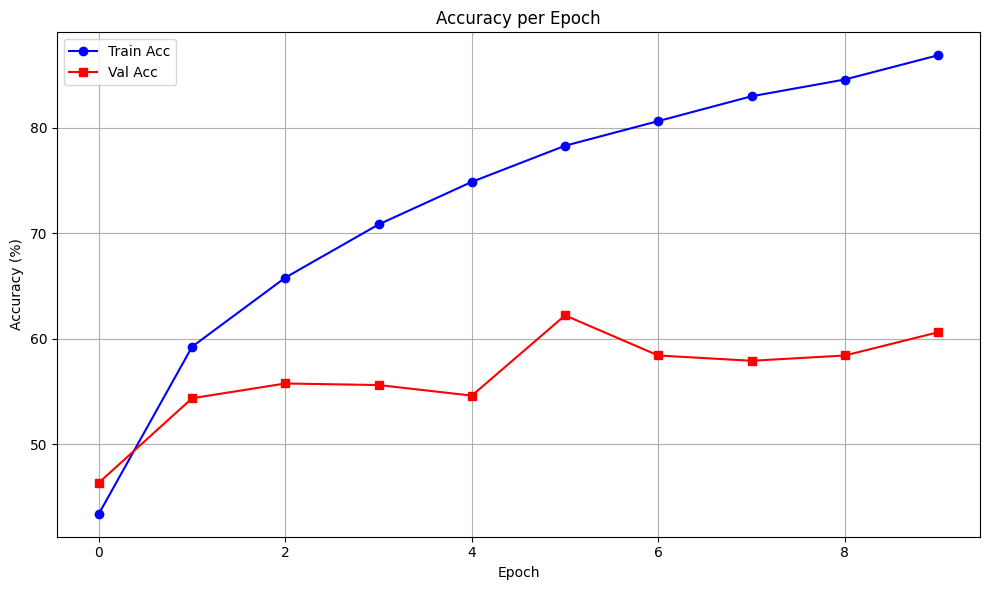

Test Loss: 1.2757, Test Accuracy: 60.80%


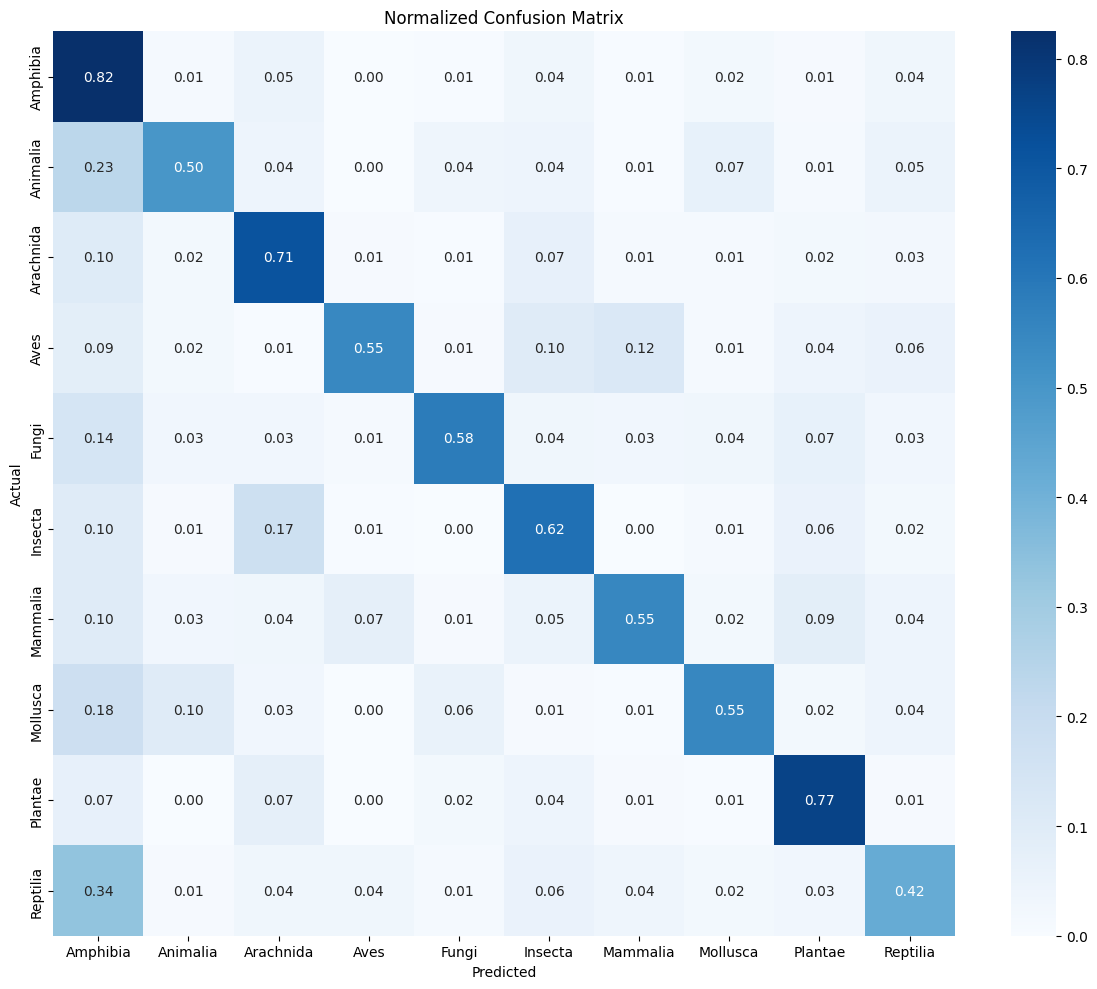

Total training time: 558.62s


In [ ]:
model = fine_tune_model(10,5,'last','adam')
